In [1]:
%%capture --no-display
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import h5py
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook(range(0))

0it [00:00, ?it/s]

### Define paths for the model and data of interest

In [2]:
tf_name = "MAX"
num_tasks = 7
fold_num = 1
task_index = 0

files_spec_path = "/users/amtseng/tfmodisco/data/processed/ENCODE/config/{0}/{0}_training_paths.json".format(tf_name)

mt_model_path = "/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_multitask_profile_finetune_fold1_model.h5"
st_model_path = "/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_singletask_profile_finetune_task0_fold1_model.h5"

mt_imp_score_path = "/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_multitask_profile_finetune_task0_fold1_imp_scores.h5"
st_imp_score_path = "/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_singletask_profile_finetune_task0_fold1_imp_scores.h5"

In [3]:
# Define the paths to the files and model, and some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
chrom_splits_json = "/users/amtseng/tfmodisco/data/processed/ENCODE/chrom_splits.json"
input_length = 2114
profile_length = 1000

In [4]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_beds = files_spec["peak_beds"]
profile_hdf5 = files_spec["profile_hdf5"]

In [5]:
# Get chromosome sets
with open(chrom_splits_json, "r") as f:
    chrom_splits = json.load(f)
split = chrom_splits[str(fold_num)]
train_chroms, val_chroms, test_chroms = split["train"], split["val"], split["test"]
all_chroms = train_chroms + val_chroms + test_chroms

In [6]:
# Import the model
custom_objects = {
    "kb": keras.backend,
    "profile_loss": (lambda true_vals, pred_vals: keras.backend.sum(pred_vals)),
    "count_loss": (lambda true_vals, pred_vals: keras.backend.sum(pred_vals))
}
mt_model = keras.models.load_model(mt_model_path, custom_objects=custom_objects)
st_model = keras.models.load_model(st_model_path, custom_objects=custom_objects)

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [7]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2)

In [8]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(
    peaks_beds[task_index], sep="\t", header=None,  # Infer compression
    names=[
        "chrom", "peak_start", "peak_end", "name", "score",
        "strand", "signal", "pval", "qval", "summit_offset"
    ]
)
pos_coords_table = pos_coords_table[pos_coords_table["chrom"].isin(test_chroms)]

# Summit-center them; this is very important!
summit = pos_coords_table["peak_start"] + pos_coords_table["summit_offset"]
pos_coords_table["start"] = summit - (input_length // 2)
pos_coords_table["end"] = pos_coords_table["start"] + input_length
pos_coords = pos_coords_table[["chrom", "start", "end"]].values

### Predicting

In [9]:
def predict_coords(model, coords, task_index=None):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned predicted profiles are in terms of log probabilities, and the
    returned predicted counts are also log. Returned values are all NumPy arrays.
    """
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    true_profs = profiles[:, :num_tasks]
    cont_profs = profiles[:, num_tasks:]
    true_counts = np.sum(true_profs, axis=2)
    
    if task_index is not None:
        true_profs = true_profs[:, task_index : task_index + 1]
        cont_profs = cont_profs[:, task_index : task_index + 1]

    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict([input_seqs, cont_profs])
    
    # Convert logit profile predictions to log probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(
        logit_pred_profs
    )
    
    return log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs

In [10]:
num_coords = len(pos_coords)

mt_log_pred_profs = np.empty((num_coords, profile_length, 2))
mt_log_pred_counts = np.empty((num_coords, 2))
st_log_pred_profs = np.empty((num_coords, profile_length, 2))
st_log_pred_counts = np.empty((num_coords, 2))
true_profs = np.empty((num_coords, profile_length, 2))
true_counts = np.empty((num_coords, 2))
input_seqs = np.empty((num_coords, input_length, 4))

batch_size = 128
num_batches = int(np.ceil(num_coords / batch_size))
for i in tqdm.notebook.trange(num_batches):
    batch_slice = slice(i * batch_size, (i + 1) * batch_size)
    
    b_mt_log_pred_profs, b_mt_log_pred_counts, b_mt_true_profs, b_mt_true_counts, b_mt_input_seqs =\
        predict_coords(mt_model, pos_coords[batch_slice])
    b_st_log_pred_profs, b_st_log_pred_counts, b_st_true_profs, b_st_true_counts, b_st_input_seqs =\
        predict_coords(st_model, pos_coords[batch_slice], task_index)
    
    # Limit predictions to just the one task
    b_mt_log_pred_profs = b_mt_log_pred_profs[:, task_index]
    b_mt_log_pred_counts = b_mt_log_pred_counts[:, task_index]
    b_mt_true_profs = b_mt_true_profs[:, task_index]
    b_mt_true_counts = b_mt_true_counts[:, task_index]
    b_st_log_pred_profs = b_st_log_pred_profs[:, 0]
    b_st_log_pred_counts = b_st_log_pred_counts[:, 0]
    b_st_true_profs = b_st_true_profs[:, 0]
    b_st_true_counts = b_st_true_counts[:, 0]
    
    assert np.all(b_mt_input_seqs == b_st_input_seqs)
    assert np.all(b_mt_true_profs == b_st_true_profs)
    assert np.all(b_mt_true_counts == b_st_true_counts)

    mt_log_pred_profs[batch_slice] = b_mt_log_pred_profs
    mt_log_pred_counts[batch_slice] = b_mt_log_pred_counts
    st_log_pred_profs[batch_slice] = b_st_log_pred_profs
    st_log_pred_counts[batch_slice] = b_st_log_pred_counts
    true_profs[batch_slice] = b_mt_true_profs
    true_counts[batch_slice] = b_mt_true_counts
    input_seqs[batch_slice] = b_mt_input_seqs

### View count correlations

In [11]:
log_true_counts = np.log(true_counts + 1)

print("Spearman:")
print("MT", scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(mt_log_pred_counts))[0])
print("ST", scipy.stats.spearmanr(np.ravel(log_true_counts), np.ravel(st_log_pred_counts))[0])

print("Pearson:")
print("MT", scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(mt_log_pred_counts))[0])
print("ST", scipy.stats.pearsonr(np.ravel(log_true_counts), np.ravel(st_log_pred_counts))[0])

Spearman:
MT 0.7494401920173741
ST 0.7399316301997699
Pearson:
MT 0.7486692684253555
ST 0.7345571981702936


### View DeepSHAP importances with cofactor

In [12]:
center_plot_size = 400
start = (input_length // 2) - (center_plot_size // 2)
end = start + center_plot_size
center_slice = slice(start, end)

In [13]:
def dna_to_one_hot(seqs):
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)
    seq_concat = "".join(seqs).upper() + "ACGT"
    one_hot_map = np.identity(5)[:, :-1]
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85
    _, base_inds = np.unique(base_vals, return_inverse=True)
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

def one_hot_to_dna(one_hot):
    bases = np.array(["A", "C", "G", "T", "N"])
    one_hot_inds = np.tile(one_hot.shape[2], one_hot.shape[:2])
    batch_inds, seq_inds, base_inds = np.where(one_hot)
    one_hot_inds[batch_inds, seq_inds] = base_inds
    seq_array = bases[one_hot_inds]
    return ["".join(seq) for seq in seq_array]

def revcomp_dna(seq):
    rc_dict = {"A": "T", "T": "A", "C": "G", "G": "C"}
    return "".join([rc_dict[c] for c in seq][::-1])

In [14]:
input_dna_seqs = one_hot_to_dna(input_seqs)
contains_cofactor = np.array([
    ("GATAA" in s[center_slice] or "TTATC" in s[center_slice]) for s in input_dna_seqs
])

In [15]:
sample_size = 5
coord_samp_with_cofactor = pos_coords[np.random.choice(np.where(contains_cofactor)[0], size=sample_size, replace=False)]

/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_multitask_profile_finetune_task0_fold1_imp_scores.h5
['chr1' 21790842 21792956]


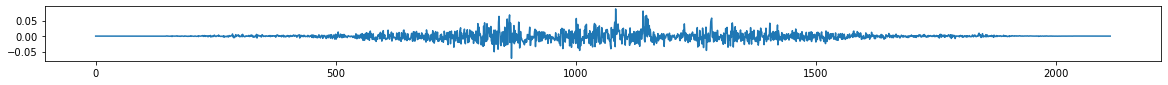

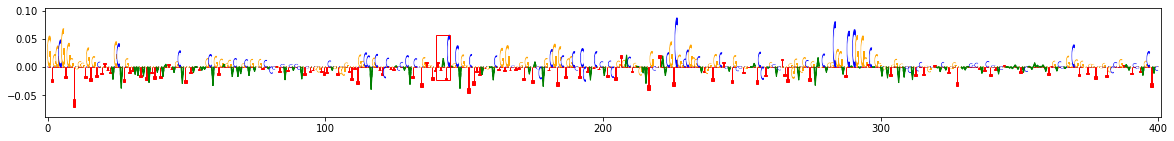

['chr1' 8570740 8572854]


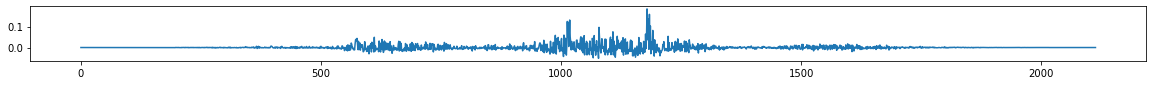

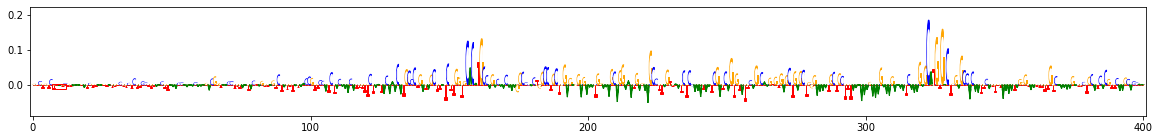

['chr1' 110103740 110105854]


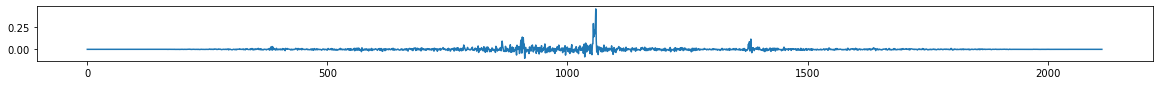

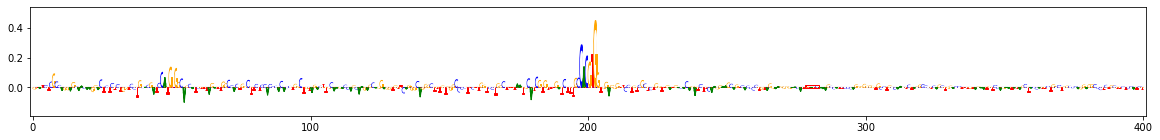

['chr1' 28391172 28393286]


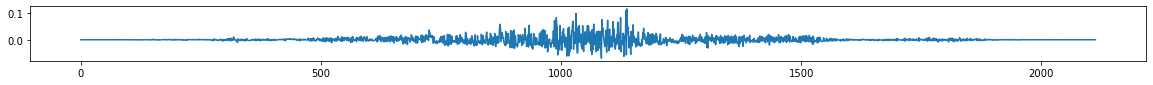

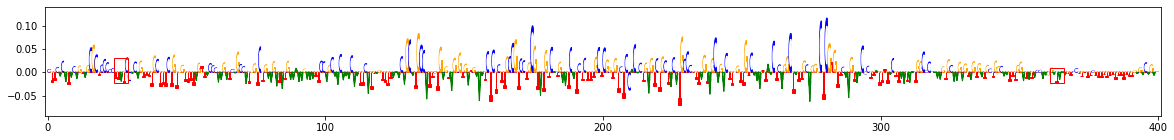

['chr1' 67685749 67687863]


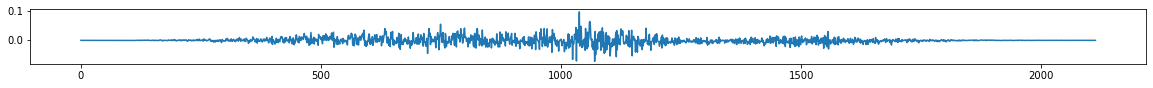

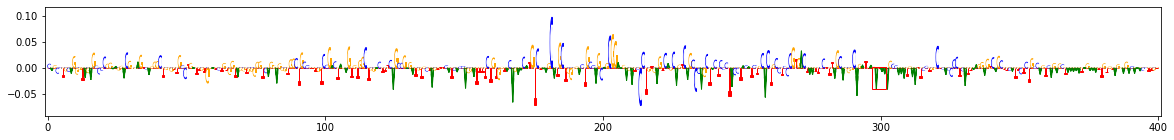

/mnt/lab_data2/amtseng/misc/multitask_singletask_perf_motif/MAX_singletask_profile_finetune_task0_fold1_imp_scores.h5
['chr1' 21790842 21792956]


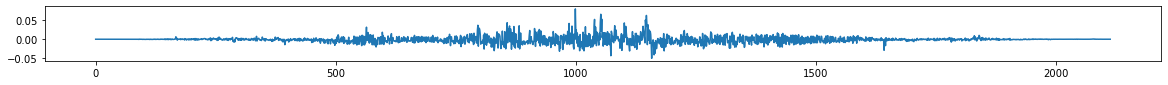

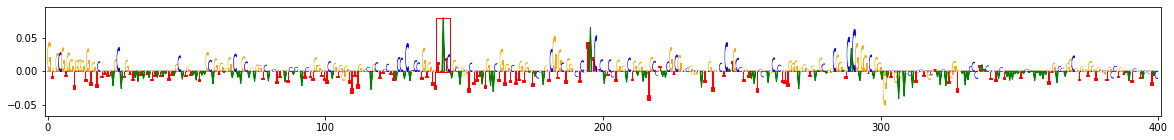

['chr1' 8570740 8572854]


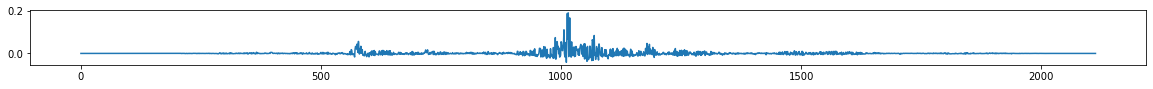

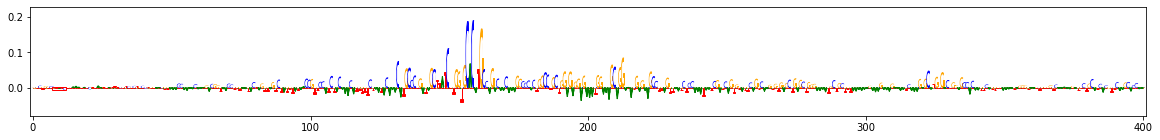

['chr1' 110103740 110105854]


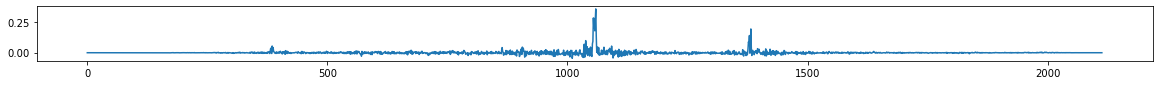

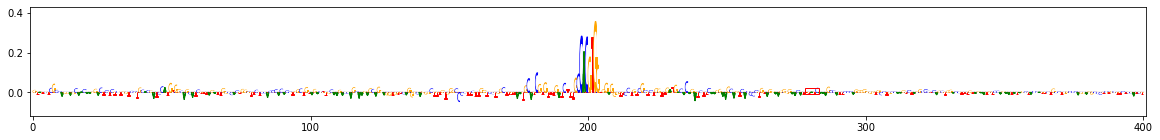

['chr1' 28391172 28393286]


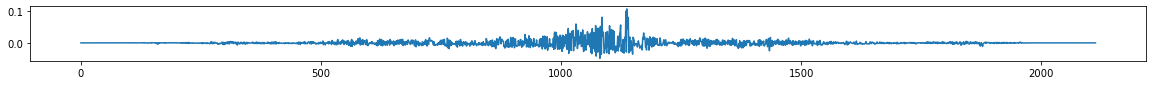

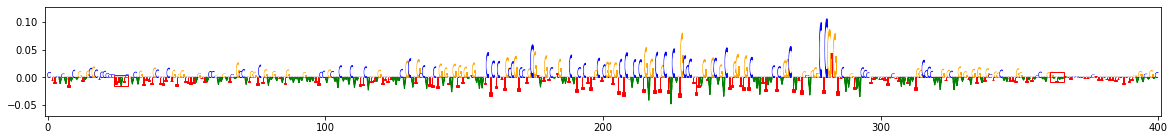

['chr1' 67685749 67687863]


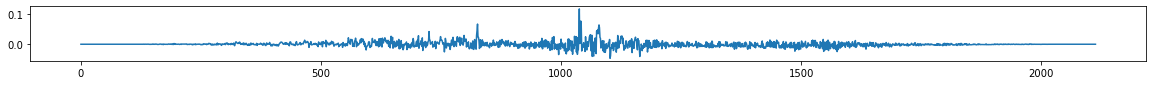

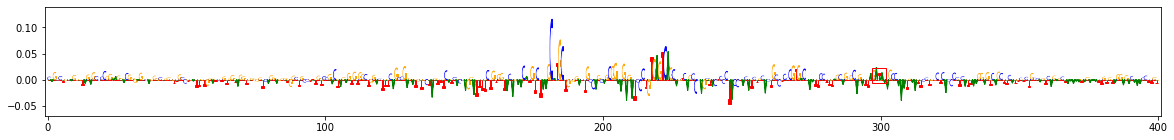

In [16]:
for path in (mt_imp_score_path, st_imp_score_path):
    print(path)
    with h5py.File(path, "r") as f:
        c = np.empty((len(f["coords_start"]), 3), dtype=object)
        c[:, 0] = f["coords_chrom"][:].astype(str)
        c[:, 1] = f["coords_start"][:]
        c[:, 2] = f["coords_end"][:]

        for coord in coord_samp_with_cofactor:
            print(coord)
            index = np.where((c[:, 0] == coord[0]) & (c[:, 1] == coord[1]))[0][0]
            hyp_scores, input_seq = f["count_hyp_scores"][index], f["input_seqs"][index]
            act_scores = hyp_scores * input_seq
            seq = one_hot_to_dna(input_seq[None])[0][center_slice]
            starts = [seq.find(s) for s in ("GATAA", "TTATC")]
            highlights = [(start, start + 5) for start in starts if start >= 0]
            plt.figure(figsize=(20, 1))
            plt.plot(np.sum(act_scores, axis=1))
            plt.show()
            viz_sequence.plot_weights(
                act_scores[center_slice], highlight={"red": highlights},
                subticks_frequency=100
            )
    print("====================================")

### Count predictions with disrupted/inserted cofactor

In [17]:
def mutate_cofactor_predict(model, coords, motif, mode="remove", task_index=None):
    """
    From the given coordinates, adds or removes a cofactor motif to the
    input sequences and computes the predictions.
    """
    assert mode in ("add", "remove")
    input_seqs, profiles = coords_to_network_inputs(coords)
    
    true_profs = profiles[:, :num_tasks]
    cont_profs = profiles[:, num_tasks:]
    true_counts = np.sum(true_profs, axis=2)
    
    if task_index is not None:
        true_profs = true_profs[:, task_index : task_index + 1]
        cont_profs = cont_profs[:, task_index : task_index + 1]
        
    def scramble(one_hot):
        return np.identity(4)[(np.where(one_hot)[1] + 1) % 4]
    
    rc_motif = revcomp_dna(motif)
    if mode == "remove":
        for i in range(len(input_seqs)):
            seq = one_hot_to_dna(input_seqs[i][center_slice][None])[0]
            assert motif in seq or rc_motif in seq
            index = max(
                one_hot_to_dna(input_seqs[i][None])[0].find(motif),
                one_hot_to_dna(input_seqs[i][None])[0].find(rc_motif)
            )
            while index >= 0:
                input_seqs[i][index : index + len(motif)] = scramble(input_seqs[i][index : index + len(motif)])
                index = max(
                    one_hot_to_dna(input_seqs[i][None])[0].find(motif),
                    one_hot_to_dna(input_seqs[i][None])[0].find(rc_motif)
                )
            seq = one_hot_to_dna(input_seqs[i][center_slice][None])[0]
            assert motif not in seq and rc_motif not in seq
    else:
        motif_one_hot = dna_to_one_hot([motif])[0]
        rc_motif_one_hot = dna_to_one_hot([rc_motif])[0]
        for i in range(len(input_seqs)):
            seq = one_hot_to_dna(input_seqs[i][center_slice][None])[0]
            assert motif not in seq and rc_motif not in seq
            
            index = np.random.choice(center_plot_size - len(motif))
            index = index + ((input_length - center_plot_size) // 2)
            input_seqs[i][index : index + len(motif)] = (motif_one_hot, rc_motif_one_hot)[np.random.choice(2)]
            
            seq = one_hot_to_dna(input_seqs[i][center_slice][None])[0]
            assert motif in seq or rc_motif in seq

    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict([input_seqs, cont_profs])
    
    # Convert logit profile predictions to log probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(
        logit_pred_profs
    )
    
    return log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs

In [18]:
coords_with_cofactor = pos_coords[contains_cofactor]
coords_without_cofactor = pos_coords[~contains_cofactor]

In [19]:
# Remove cofactor from sequences with one
num_coords = len(coords_with_cofactor)

mt_remove_log_pred_counts = np.empty((num_coords, 2))
st_remove_log_pred_counts = np.empty((num_coords, 2))

batch_size = 128
num_batches = int(np.ceil(num_coords / batch_size))
for i in tqdm.notebook.trange(num_batches):
    batch_slice = slice(i * batch_size, (i + 1) * batch_size)
    
    _, b_mt_log_pred_counts, _, _, _ =\
        mutate_cofactor_predict(mt_model, coords_with_cofactor[batch_slice], "GATAA", "remove")
    _, b_st_log_pred_counts, _, _, _ =\
        mutate_cofactor_predict(st_model, coords_with_cofactor[batch_slice], "GATAA", "remove", task_index)
    
    # Limit predictions to just the one task
    b_mt_log_pred_counts = b_mt_log_pred_counts[:, task_index]
    b_st_log_pred_counts = b_st_log_pred_counts[:, 0]
    
    mt_remove_log_pred_counts[batch_slice] = b_mt_log_pred_counts
    st_remove_log_pred_counts[batch_slice] = b_st_log_pred_counts
    
# Add cofactor to sequences without one
num_coords = len(coords_without_cofactor)

mt_add_log_pred_counts = np.empty((num_coords, 2))
st_add_log_pred_counts = np.empty((num_coords, 2))

batch_size = 128
num_batches = int(np.ceil(num_coords / batch_size))
for i in tqdm.notebook.trange(num_batches):
    batch_slice = slice(i * batch_size, (i + 1) * batch_size)
    
    _, b_mt_log_pred_counts, _, _, _ =\
        mutate_cofactor_predict(mt_model, coords_without_cofactor[batch_slice], "GATAA", "add")
    _, b_st_log_pred_counts, _, _, _ =\
        mutate_cofactor_predict(st_model, coords_without_cofactor[batch_slice], "GATAA", "add", task_index)
    
    # Limit predictions to just the one task
    b_mt_log_pred_counts = b_mt_log_pred_counts[:, task_index]
    b_st_log_pred_counts = b_st_log_pred_counts[:, 0]
    
    mt_add_log_pred_counts[batch_slice] = b_mt_log_pred_counts
    st_add_log_pred_counts[batch_slice] = b_st_log_pred_counts

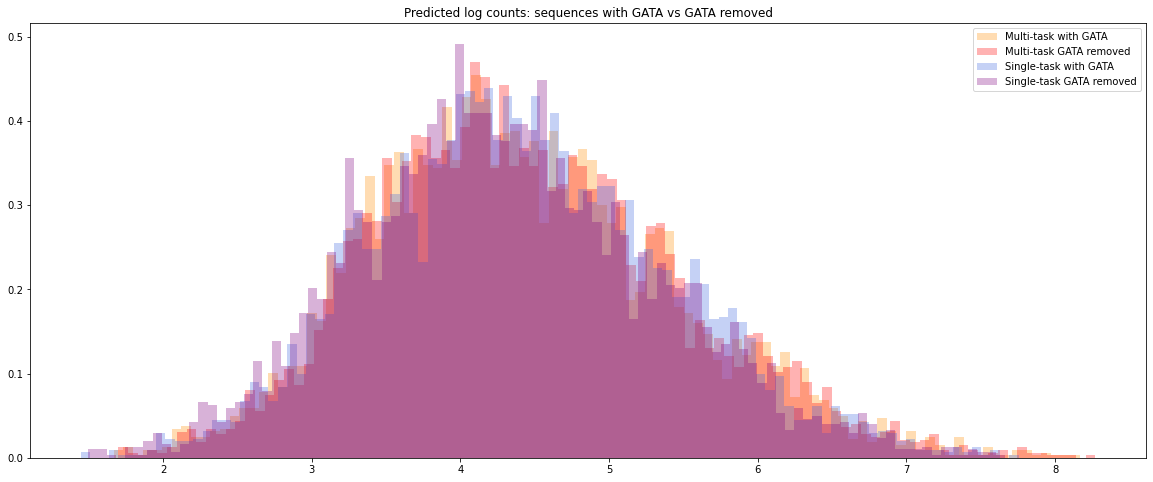

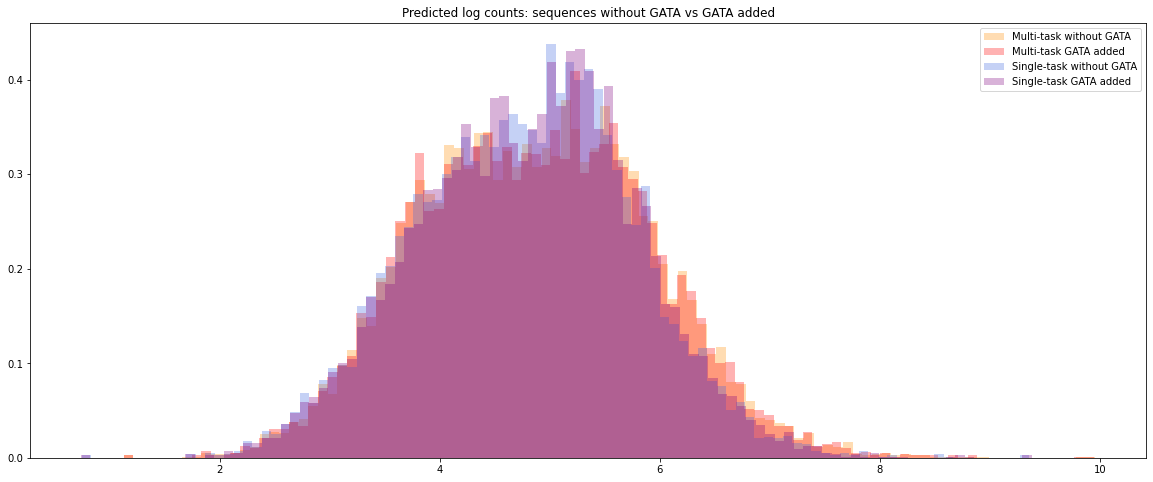

In [20]:
# Plot histograms of difference in predicted counts
fig, ax = plt.subplots(figsize=(20, 8))
num_bins = 100

ax.hist(
    np.ravel(mt_log_pred_counts[np.where(contains_cofactor)[0]]),
    bins=num_bins, color="darkorange", alpha=0.3, label="Multi-task with GATA", density=True
)
ax.hist(
    np.ravel(mt_remove_log_pred_counts),
    bins=num_bins, color="red", alpha=0.3, label="Multi-task GATA removed", density=True
)
ax.hist(
    np.ravel(st_log_pred_counts[np.where(contains_cofactor)[0]]),
    bins=num_bins, color="royalblue", alpha=0.3, label="Single-task with GATA", density=True
)
ax.hist(
    np.ravel(st_remove_log_pred_counts),
    bins=num_bins, color="purple", alpha=0.3, label="Single-task GATA removed", density=True
)
plt.legend()
plt.title("Predicted log counts: sequences with GATA vs GATA removed")
plt.show()

fig, ax = plt.subplots(figsize=(20, 8))
ax.hist(
    np.ravel(mt_log_pred_counts[np.where(~contains_cofactor)[0]]),
    bins=num_bins, color="darkorange", alpha=0.3, label="Multi-task without GATA", density=True
)
ax.hist(
    np.ravel(mt_add_log_pred_counts),
    bins=num_bins, color="red", alpha=0.3, label="Multi-task GATA added", density=True
)
ax.hist(
    np.ravel(st_log_pred_counts[np.where(~contains_cofactor)[0]]),
    bins=num_bins, color="royalblue", alpha=0.3, label="Single-task without GATA", density=True
)
ax.hist(
    np.ravel(st_add_log_pred_counts),
    bins=num_bins, color="purple", alpha=0.3, label="Single-task GATA added", density=True
)
plt.legend()
plt.title("Predicted log counts: sequences without GATA vs GATA added")
plt.show()

### True counts with vs without cofactor

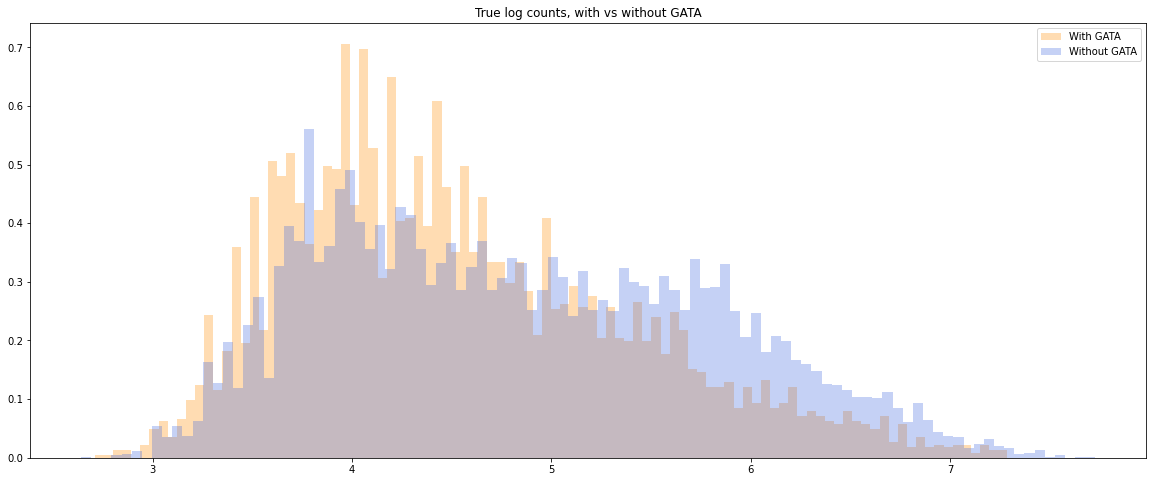

In [21]:
log_true_counts = np.log(true_counts + 1)

fig, ax = plt.subplots(figsize=(20, 8))
ax.hist(
    np.ravel(log_true_counts[contains_cofactor]),
    bins=num_bins, color="darkorange", alpha=0.3, label="With GATA", density=True
)
ax.hist(
    np.ravel(log_true_counts[~contains_cofactor]),
    bins=num_bins, color="royalblue", alpha=0.3, label="Without GATA", density=True
)
plt.legend()
plt.title("True log counts, with vs without GATA")
plt.show()